In [1]:
import numpy as np
import subprocess
import tqdm
import pandas as pd


import os
import os.path as osp

import glob

import h5py
import uproot

import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader

import awkward as ak
import random

In [17]:
import glob
import os.path as osp
import uproot
import awkward as ak
import torch
import numpy as np
import random
import tqdm
from torch_geometric.data import Data, Dataset

import numpy as np
import subprocess
import tqdm
import pandas as pd

import os
import os.path as osp

import glob

import h5py
import uproot

import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader

import awkward as ak
import random
def find_highest_branch(path, base_name):
    with uproot.open(path) as f:
        # Find keys that exactly match the base_name (not containing other variations)
        branches = [k for k in f.keys() if k.startswith(base_name + ';')]
        
        # Sort and select the highest-numbered branch
        sorted_branches = sorted(branches, key=lambda x: int(x.split(';')[-1]))
        return sorted_branches[-1] if sorted_branches else None

class CCV1(Dataset):
    r'''
    Loads trackster-level features and associations for positive/negative edge creation.
    '''

    url = '/dummy/'

    def __init__(self, root, transform=None, max_events=1e8, inp='train'):
        super(CCV1, self).__init__(root, transform)
        self.inp = inp
        self.max_events = max_events
        self.fill_data(max_events)

    def fill_data(self, max_events):
        counter = 0
        print("### Loading tracksters data")


        for path in tqdm.tqdm(self.raw_paths):
            print(path)
            
            #tracksters_path = find_highest_branch(path, 'tracksters')
            #associations_path = find_highest_branch(path, 'associations')
            #simtrack = find_highest_branch(path, 'simtrackstersCP')
            
            tracksters_path = find_highest_branch(path, 'tracksters')
            associations_path = find_highest_branch(path, 'associations')
            simtrack = find_highest_branch(path, 'simtrackstersCP')
            # Load tracksters features in chunks
            for array in uproot.iterate(
                f"{path}:{tracksters_path}",
                [
                    "time", "raw_energy",
                    "barycenter_x", "barycenter_y", "barycenter_z", 
                    "barycenter_eta", "barycenter_phi",
                    "EV1", "EV2", "EV3",
                    "eVector0_x", "eVector0_y", "eVector0_z",
                    "sigmaPCA1", "sigmaPCA2", "sigmaPCA3"
                ],
            ):

                tmp_time = array["time"]
                tmp_raw_energy = array["raw_energy"]
                tmp_bx = array["barycenter_x"]
                tmp_by = array["barycenter_y"]
                tmp_bz = array["barycenter_z"]
                tmp_beta = array["barycenter_eta"]
                tmp_bphi = array["barycenter_phi"]
                tmp_EV1 = array["EV1"]
                tmp_EV2 = array["EV2"]
                tmp_EV3 = array["EV3"]
                tmp_eV0x = array["eVector0_x"]
                tmp_eV0y = array["eVector0_y"]
                tmp_eV0z = array["eVector0_z"]
                tmp_sigma1 = array["sigmaPCA1"]
                tmp_sigma2 = array["sigmaPCA2"]
                tmp_sigma3 = array["sigmaPCA3"]
                
                
                vert_array = []
                for vert_chunk in uproot.iterate(
                    f"{path}:{simtrack}",
                    ["barycenter_x"],
                ):
                    vert_array = vert_chunk["barycenter_x"]
                    break  # Since we have a matching chunk, no need to continue
                

                # Now load the associations for the same events/chunk
                # 'tsCLUE3D_recoToSim_CP' gives association arrays like [[1,0],[0,1],...]
                # Make sure we read from the same events
                assoc_array = []
                for assoc_chunk in uproot.iterate(
                    f"{path}:{associations_path}",
                    ["tsCLUE3D_recoToSim_CP"],
                ):
                    assoc_array = assoc_chunk["tsCLUE3D_recoToSim_CP"]
                    break  # Since we have a matching chunk, no need to continue
                
                
                skim_mask = []
                if self.inp == "train": 
                    for e in vert_array:
                        if 1 <= len(e) <= 5:
                            skim_mask.append(True)
                        else:
                            skim_mask.append(False)
                else:
                    for e in vert_array:
                        if 1 <= len(e) <= 5:
                            skim_mask.append(True)
                        else:
                            skim_mask.append(False)

                tmp_time = tmp_time[skim_mask]
                tmp_raw_energy = tmp_raw_energy[skim_mask]
                tmp_bx = tmp_bx[skim_mask]
                tmp_by = tmp_by[skim_mask]
                tmp_bz = tmp_bz[skim_mask]
                tmp_beta = tmp_beta[skim_mask]
                tmp_bphi = tmp_bphi[skim_mask]
                tmp_EV1 = tmp_EV1[skim_mask]
                tmp_EV2 = tmp_EV2[skim_mask]
                tmp_EV3 = tmp_EV3[skim_mask]
                tmp_eV0x = tmp_eV0x[skim_mask]
                tmp_eV0y = tmp_eV0y[skim_mask]
                tmp_eV0z = tmp_eV0z[skim_mask]
                tmp_sigma1 = tmp_sigma1[skim_mask]
                tmp_sigma2 = tmp_sigma2[skim_mask]
                tmp_sigma3 = tmp_sigma3[skim_mask]
                
                assoc_array = assoc_array[skim_mask]
                
                
                # Concatenate or initialize storage
                if counter == 0:
                    self.time = tmp_time
                    self.raw_energy = tmp_raw_energy
                    self.bx = tmp_bx
                    self.by = tmp_by
                    self.bz = tmp_bz
                    self.beta = tmp_beta
                    self.bphi = tmp_bphi
                    self.EV1 = tmp_EV1
                    self.EV2 = tmp_EV2
                    self.EV3 = tmp_EV3
                    self.eV0x = tmp_eV0x
                    self.eV0y = tmp_eV0y
                    self.eV0z = tmp_eV0z
                    self.sigma1 = tmp_sigma1
                    self.sigma2 = tmp_sigma2
                    self.sigma3 = tmp_sigma3
                    self.assoc = assoc_array
                else:
                    self.time = ak.concatenate((self.time, tmp_time))
                    self.raw_energy = ak.concatenate((self.raw_energy, tmp_raw_energy))
                    self.bx = ak.concatenate((self.bx, tmp_bx))
                    self.by = ak.concatenate((self.by, tmp_by))
                    self.bz = ak.concatenate((self.bz, tmp_bz))
                    self.beta = ak.concatenate((self.beta, tmp_beta))
                    self.bphi = ak.concatenate((self.bphi, tmp_bphi))
                    self.EV1 = ak.concatenate((self.EV1, tmp_EV1))
                    self.EV2 = ak.concatenate((self.EV2, tmp_EV2))
                    self.EV3 = ak.concatenate((self.EV3, tmp_EV3))
                    self.eV0x = ak.concatenate((self.eV0x, tmp_eV0x))
                    self.eV0y = ak.concatenate((self.eV0y, tmp_eV0y))
                    self.eV0z = ak.concatenate((self.eV0z, tmp_eV0z))
                    self.sigma1 = ak.concatenate((self.sigma1, tmp_sigma1))
                    self.sigma2 = ak.concatenate((self.sigma2, tmp_sigma2))
                    self.sigma3 = ak.concatenate((self.sigma3, tmp_sigma3))
                    self.assoc = ak.concatenate((self.assoc, assoc_array))

                counter += len(tmp_bx)
                if counter >= max_events:
                    print(f"Reached {max_events} events!")
                    break
            if counter >= max_events:
                break

    def download(self):
        raise RuntimeError(
            f'Dataset not found. Please download it from {self.url} and move all '
            f'*.root files to {self.raw_dir}')

    def len(self):
        return len(self.time)

    @property
    def raw_file_names(self):
        raw_files = sorted(glob.glob(osp.join(self.raw_dir, '*.root')))
        return raw_files

    @property
    def processed_file_names(self):
        return []

    def get(self, idx):
        # Extract per-event arrays
        event_time = self.time[idx]
        event_raw_energy = self.raw_energy[idx]
        event_bx = self.bx[idx]
        event_by = self.by[idx]
        event_bz = self.bz[idx]
        event_beta = self.beta[idx]
        event_bphi = self.bphi[idx]
        event_EV1 = self.EV1[idx]
        event_EV2 = self.EV2[idx]
        event_EV3 = self.EV3[idx]
        event_eV0x = self.eV0x[idx]
        event_eV0y = self.eV0y[idx]
        event_eV0z = self.eV0z[idx]
        event_sigma1 = self.sigma1[idx]
        event_sigma2 = self.sigma2[idx]
        event_sigma3 = self.sigma3[idx]
        event_assoc = self.assoc[idx]  # Each is now an array (e.g., [0, 1, 2]) indicating the pion group

        # Convert each to numpy arrays if needed
        event_time = np.array(event_time)
        event_raw_energy = np.array(event_raw_energy)
        event_bx = np.array(event_bx)
        event_by = np.array(event_by)
        event_bz = np.array(event_bz)
        event_beta = np.array(event_beta)
        event_bphi = np.array(event_bphi)
        event_EV1 = np.array(event_EV1)
        event_EV2 = np.array(event_EV2)
        event_EV3 = np.array(event_EV3)
        event_eV0x = np.array(event_eV0x)
        event_eV0y = np.array(event_eV0y)
        event_eV0z = np.array(event_eV0z)
        event_sigma1 = np.array(event_sigma1)
        event_sigma2 = np.array(event_sigma2)
        event_sigma3 = np.array(event_sigma3)
        event_assoc = np.array(event_assoc)  # e.g. [[0,1,2], [2,0,1], [1,0,2], ...]

        # Combine features
        flat_feats = np.column_stack((
            event_bx, event_by, event_bz, event_raw_energy,
            event_beta, event_bphi,
            event_EV1, event_EV2, event_EV3,
            event_eV0x, event_eV0y, event_eV0z,
            event_sigma1, event_sigma2, event_sigma3
        ))
        x = torch.from_numpy(flat_feats).float()

        total_tracksters = len(event_time)

        # --------------------------------------------------------------------
        # Group tracksters by their association tuple. Two tracksters belong
        # to the same pion group if their association arrays (converted to tuples)
        # match.
        # --------------------------------------------------------------------
        # Group tracksters by their association tuple
         # Group tracksters by the first element of event_assoc
        assoc_groups = {}
        for i, assoc in enumerate(event_assoc):
            key = assoc[0]  # Only use the first element as the key
            if key not in assoc_groups:
                assoc_groups[key] = []
            assoc_groups[key].append(i)

        pos_edges = []
        neg_edges = []

        # Ensure positive edges always connect to another trackster in the same group if possible
        for i in range(total_tracksters):
            key = event_assoc[i][0]  # Get first element as group identifier
            same_group = assoc_groups[key]

            # --- Positive edge ---
            if len(same_group) > 1:
                # Always select another trackster from the same group
                pos_target = random.choice([j for j in same_group if j != i])
            else:
                # No other trackster in the group, form a self-loop
                pos_target = i
            pos_edges.append([i, pos_target])

            # --- Negative edge ---
            neg_candidates = [j for j in range(total_tracksters) if event_assoc[j][0] != key]
            if neg_candidates:
                neg_target = random.choice(neg_candidates)
            else:
                neg_target = i
            neg_edges.append([i, neg_target])

        x_pos_edge = torch.tensor(pos_edges, dtype=torch.long)
        x_neg_edge = torch.tensor(neg_edges, dtype=torch.long)

        return Data(x=x, x_pe=x_pos_edge, x_ne=x_neg_edge)

In [18]:
ipath = "/vols/cms/mm1221/Data/100k/5e/train/"

In [19]:
data_train = CCV1(ipath, max_events=100000, inp = 'train')

### Loading tracksters data


  0%|                                                                                                                                                             | 0/3 [00:00<?, ?it/s]

/vols/cms/mm1221/Data/100k/5e/train/raw/18k5e.root


 33%|█████████████████████████████████████████████████▋                                                                                                   | 1/3 [00:03<00:06,  3.42s/it]

/vols/cms/mm1221/Data/100k/5e/train/raw/2k5e.root


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2/3 [00:03<00:01,  1.69s/it]

/vols/cms/mm1221/Data/100k/5e/train/raw/train.root


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.12s/it]


In [20]:
print(data_train)

CCV1(80000)


In [21]:
seen_events = {}  # Dictionary to store event representations with their indices
duplicates_found = False
duplicate_count = 0  # Total number of duplicate events

for i, data in enumerate(data_train):
    event_tuple = tuple(data.x.flatten().tolist())  # Flatten and convert to tuple for comparison
    if event_tuple in seen_events:
        original_index = seen_events[event_tuple]  # Retrieve the index of the first occurrence
        print(f"Duplicate found at index {i}, matches event at index {original_index}")
        duplicates_found = True
        duplicate_count += 1
    else:
        seen_events[event_tuple] = i  # Store the index of this unique event

if not duplicates_found:
    print("No duplicates found!")


KeyboardInterrupt: 

In [37]:
print(data_train[10].x_pe)

tensor([[0, 5],
        [1, 3],
        [2, 2],
        [3, 1],
        [4, 4],
        [5, 0]])


In [23]:
v_file = uproot.open("/vols/cms/mm1221/Data/100k/5e/train/raw/18k5e.root")

In [24]:
ass = v_file['associations;1']['tsCLUE3D_recoToSim_CP'].array()

In [25]:
for i in range(len(ass[10])):
    print(ass[10][i])

[0, 1, 2]
[2, 1, 0]
[1, 0, 2]


In [19]:
cp = v_file['simtrackstersCP;3']['vertices_indexes'].array()

In [21]:
print(len(cp[2]))

5


In [48]:
EV1 = v_file['tracksters;1']['EV1'].array()
EV2 = v_file['tracksters;1']['EV2'].array()
EV3 = v_file['tracksters;1']['EV3'].array()

In [60]:
print(EV1[1][4], EV2[1][4], EV3[1][4])
print(EV1[1][5], EV2[1][5], EV3[1][5])

38.269657135009766 0.5027532577514648 0.19676074385643005
8.671971321105957 0.5754814147949219 1.453372686956167e-12


In [64]:
e_x = v_file['tracksters;1']['eVector0_x'].array()
e_y = v_file['tracksters;1']['eVector0_y'].array()
e_z = v_file['tracksters;1']['eVector0_z'].array()

In [65]:
print(e_x[1][4], e_y[1][4], e_z[1][4])
print(e_x[1][5], e_y[1][5], e_z[1][5])

-0.10173875838518143 -0.13727739453315735 0.9852939248085022
0.17315226793289185 -0.4776451289653778 0.8613207340240479


In [68]:
sig1 = v_file['tracksters;1']['sigmaPCA1'].array()
sig2 = v_file['tracksters;1']['sigmaPCA2'].array()
sig3 = v_file['tracksters;1']['sigmaPCA3'].array()

In [69]:
print(sig1[1][4], sig2[1][4], sig3[1][4])
print(sig1[1][5], sig2[1][5], sig3[1][5])

5.845280647277832 1.4954370260238647 1.6017284393310547
1.7081390619277954 1.682658314704895 1.8703943490982056


In [53]:
ass = v_file['associations;1']['tsCLUE3D_recoToSim_CP'].array()

In [56]:
for i in range(len(ass[1])):
    print(ass[1][i])

[1, 0, 2, 4, 3]
[2, 0, 1, 3, 4]
[3, 4, 0, 2, 1]
[4, 3, 0, 2, 1]
[0, 2, 1, 4, 3]
[0, 1, 2, 3, 4]


In [61]:
print(data_train[1].x_pe)

tensor([[0, 1],
        [1, 0],
        [2, 3],
        [3, 2],
        [4, 5],
        [5, 4],
        [6, 7],
        [7, 6],
        [8, 9],
        [9, 8]])


In [33]:
print(np.min(v_y[0][0]),np.max(v_y[0][0]))

-100.77678680419922 -90.07955169677734


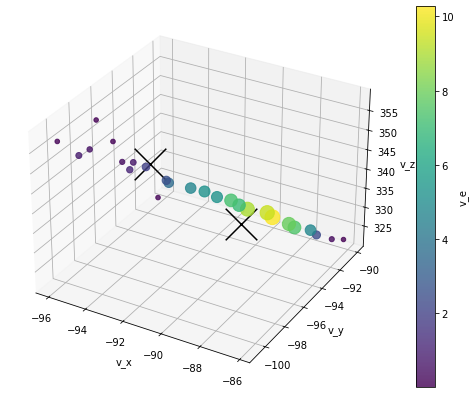

In [158]:
# Normalize v_e for better visibility
sizes = (v_e[0][0] - np.min(v_e[0][0])) / (np.max(v_e[0][0]) - np.min(v_e[0][0])) * 200 + 20  # Scale and shift for better visibility

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(v_x[0][0], v_y[0][0], v_z[0][0], s=sizes, c=v_e[0][0], cmap='viridis', alpha=0.8)
ax.scatter(data_train[0].x[0][0], data_train[0].x[0][1], data_train[0].x[0][2], color='black', s=1000, marker='x', label='New Point')
ax.scatter(data_train[0].x[1][0], data_train[0].x[1][1], data_train[0].x[1][2], color='black', s=1000, marker='x', label='New Point')

# Labels and colorbar
ax.set_xlabel('v_x')
ax.set_ylabel('v_y')
ax.set_zlabel('v_z')
plt.colorbar(sc, label='v_e')

# Show plot
plt.show()

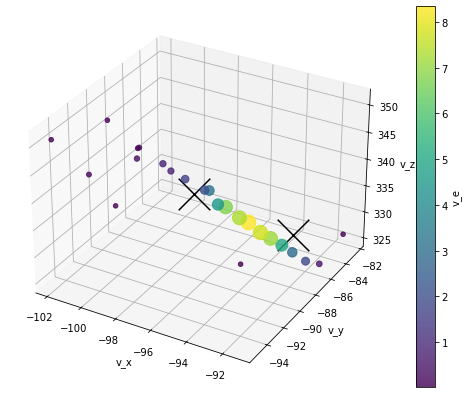

In [160]:

# Normalize v_e for better visibility
sizes = (v_e[0][1] - np.min(v_e[0][1])) / (np.max(v_e[0][1]) - np.min(v_e[0][1])) * 200 + 20  # Scale and shift for better visibility

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(v_x[0][1], v_y[0][1], v_z[0][1], s=sizes, c=v_e[0][1], cmap='viridis', alpha=0.8)
ax.scatter(data_train[0].x[2][0], data_train[0].x[2][1], data_train[0].x[2][2], color='black', s=1000, marker='x', label='New Point')
ax.scatter(data_train[0].x[3][0], data_train[0].x[3][1], data_train[0].x[3][2], color='black', s=1000, marker='x', label='New Point')

# Labels and colorbar
ax.set_xlabel('v_x')
ax.set_ylabel('v_y')
ax.set_zlabel('v_z')
plt.colorbar(sc, label='v_e')

# Show plot
plt.show()